# Developing a Women's Pro Hockey Expected Goals (xG) Model

#### Brian Johns, February 2026

As hockey continues to evolve through analytics, having an effective Expected Goals (xG) model is an expectation for proper evaluation.  Rather than depending on the relatively rare outcome of goals scored, an xG model can accumulate the relative expectation of each shot scoring, which can lead to more accurate evaluation of offensive and defensive performance.

The Professional Women's Hockey League (PWHL), and mainstream Women's Pro Hockey, is still in its infancy and plays fewer games compared to men's pro leagues, so the amount of available data is significantly lower.  Therefore, maximizing how much data can be effectively integrated can help create larger sample sizes to develop a more stable model to lead to better decision making by teams.

For this project, I am integrating data from the PWHL and the Professional Women's Hockey Players Association (PWPHA) in order to have the biggest sample possible from the top women's leagues.  Even though the PWPHA existed for a short period of time, the teams still included some of the best players in the world, many of whom still play in the PWHL today.  Treating the results on par, this will help expand the dataset to create a more accurate model.

Using this data, I hope to answer the following question:

**Can we develop an xG model to evaluate performance in women's pro hockey?**

Developing an xG model can help a team:
- Accurately measure performance on the ice
- Identify players for team building and acqusitions
- Develop on-ice lineup strategies to leverage match-up mismatches

Easy access to PWHL Stats were provided by Isabelle Lefebvre and were initially scraped on February 20th, 2026.  Detailed instructions can be found at https://github.com/IsabelleLefebvre97/PWHL-Data-Reference

A previous data visualization hosted by Sport Logiq provided data that including comprehensive data from the 2021 PWHPA season.  Information about the contest can be found at https://www.whkyhac.com/viz-launchpad

For this project, there are four notebooks.

1. Data Acquistion & Cleaning
2. Feature Engineering & EDA 
3. xG Model Development Using Classification Models
4. Final Summary & Analysis

# Notebook #1: Data Acquisition & Cleaning

In this notebook, I will show the following:

1. [Scraping PWHL Data](#scraping)
2. [Loading PWHPA Data](#loading)
3. [Merging PWHL & PWHPA Datasets](#merging)
4. [Finalizing Clean Full Dataset](#finalizing)

In researching the data for this project, a number of known issues were outlined by other users.
1. The on-ice coordinates are scaled 600x300, rather than by traditional pro hockey rink dimensions (200ftx85ft)
2. Numerous issues especially early in the data collection which included:
    - 2023-24 Regular Season games being marked as preseason
    - Inconsistent shot type labeling (many listed as 'default' with no explanation)
    - Lack of Player Tracking data in the publicly available API
    
The PWHPA data is shorter in the number of games and shots, but more robust in features available.  All of these issues are taken into account to provide a combined dataset that is cleaned and maximizes what is available from both sources.

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Polygon as MplPolygon

import matplotlib.patches as patches
import json
import time
from collections import Counter

from shapely.geometry.polygon import Polygon

from shapely.geometry import Point

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

<a id = 'scraping'></a>

## 1. Scraping PWHL Data

### Initial set-up of parameters used for scraping from the HockeyTech API.

In [2]:
BASE_URL = "https://lscluster.hockeytech.com/feed/index.php"
API_KEY  = "446521baf8c38984"
CLIENT   = "pwhl"

# Confirmed season IDs
SEASONS = {
    "2024 Preseason": 2,
    "2024 Regular Season": 1,
    "2024 Playoffs": 3,
    "2024-25 Preseason": 4,
    "2024-25 Regular Season": 5,
    "2025 Playoffs": 6,
    "2025-26 Preseason": 7,
    "2025-26 Regular Season": 8
}

# Confirmed coordinate scaling (validated against 10 games of live data)
# Raw rink: X ~0-600 (no offset), Y actual boundaries 9-294 (not 0-300)
X_RAW_SCALE = 600
Y_RAW_MIN   = 9
Y_RAW_MAX   = 294
NHL_FT_X    = 200    # full rink length in feet
NHL_FT_Y    = 85     # full rink width in feet
NET_X_FT    = 89     # net position from centre ice in feet

MIN_SKATERS = 3

In [3]:
def get(params: dict) -> dict:
    """Base GET request — injects auth and returns parsed JSON."""
    params.update({"key": API_KEY, "client_code": CLIENT})
    r = requests.get(BASE_URL, params=params, timeout=10)
    r.raise_for_status()
    return r.json()

### Confirming API connection and season IDs listed above

In [4]:
seasons_raw  = get({"feed": "modulekit", "view": "seasons"})
seasons_data = seasons_raw.get("SiteKit", seasons_raw)
print(json.dumps(seasons_data, indent=2))

{
  "Parameters": {
    "feed": "modulekit",
    "view": "seasons",
    "key": "446521baf8c38984",
    "client_code": "pwhl",
    "league_id": "1",
    "season_id": "8"
  },
  "Seasons": [
    {
      "season_id": "8",
      "season_name": "2025-26 Regular Season",
      "shortname": "2025-26 Reg",
      "career": "1",
      "playoff": "0",
      "start_date": "2025-11-21",
      "end_date": "2026-04-27"
    },
    {
      "season_id": "7",
      "season_name": "2025-26 Preseason",
      "shortname": "2025-26 Preseason",
      "career": "0",
      "playoff": "0",
      "start_date": "2025-06-01",
      "end_date": "2025-11-19"
    },
    {
      "season_id": "6",
      "season_name": "2025 Playoffs",
      "shortname": "2025 Playoffs",
      "career": "1",
      "playoff": "1",
      "start_date": "2025-05-06",
      "end_date": "2025-06-03"
    },
    {
      "season_id": "5",
      "season_name": "2024-25 Regular Season",
      "shortname": "2024-25 Reg",
      "career": "1",
      "

### Pulling all of the Game IDs

In [5]:
# Function to pull ID's following the instructions given
def get_game_ids(season_id: int) -> list:
    """Return list of completed game IDs for a given season."""
    raw   = get({"feed": "modulekit", "view": "schedule", "season_id": season_id})
    data  = raw.get("SiteKit", raw)
    games = data.get("Schedule") or data.get("games") or []
    ids   = []
    for game in games:
        gid    = game.get("id") or game.get("game_id") or game.get("GameID")
        status = str(game.get("status") or game.get("game_status", ""))
        if gid and status == "4":   # status "4" = completed
            ids.append(int(gid))
    return ids

game_ids_pre1  = get_game_ids(SEASONS["2024 Preseason"])
game_ids_s1 = get_game_ids(SEASONS["2024 Regular Season"])
game_ids_post1 = get_game_ids(SEASONS["2024 Playoffs"])
game_ids_pre2 = get_game_ids(SEASONS["2024-25 Preseason"])
game_ids_s2 = get_game_ids(SEASONS["2024-25 Regular Season"])
game_ids_post2 = get_game_ids(SEASONS["2025 Playoffs"])
game_ids_pre3 = get_game_ids(SEASONS["2025-26 Preseason"])
game_ids_s3 = get_game_ids(SEASONS["2025-26 Regular Season"])

all_game_ids =\
game_ids_pre1 +\
game_ids_s1 +\
game_ids_post1 +\
game_ids_pre2 +\
game_ids_s2 +\
game_ids_post2 +\
game_ids_pre3 +\
game_ids_s3

print(f"2024 preseason: {len(game_ids_pre1)} completed games")
print(f"2024 regular season: {len(game_ids_s1)} completed games")
print(f"2024 playoffs: {len(game_ids_post1)} completed games")
print(f"2024-25 preseason: {len(game_ids_pre2)} completed games")
print(f"2024-25 regular season: {len(game_ids_s2)} completed games")
print(f"2025 playoffs: {len(game_ids_post2)} completed games")
print(f"2025-26 preseason: {len(game_ids_pre3)} completed games")
print(f"2025-26 regular season: {len(game_ids_s3)} completed games")

print(f"Total:                  {len(all_game_ids)} games")
print(f"ID range: {min(all_game_ids)} to {max(all_game_ids)}")

2024 preseason: 9 completed games
2024 regular season: 72 completed games
2024 playoffs: 13 completed games
2024-25 preseason: 6 completed games
2024-25 regular season: 90 completed games
2025 playoffs: 12 completed games
2025-26 preseason: 8 completed games
2025-26 regular season: 61 completed games
Total:                  271 games
ID range: 2 to 337


The 2024 Preseason and Regular seasons were not in sequential order in the season IDs, but have been correctly ordered here showing the correct number of regular season games played.

### Inspecting single-game play-by-play structure

My preference would be to start the analysis with any shot towards the net (akin to 'Fenwick' stats).  Unfortunately the play-by-play only includes shots on net (equivalent to 'Corsi' stats).  This is a limitation in the PWHL stats compared to what is available in the PWHPA stats, so we will have to account for that upon merging.

Here we will see the structure of the `shot` event, as well as the `penalty` event, which will help us determine when a team is on the Power Play or is Shorthanded later.

In [6]:
TEST_GAME_ID = all_game_ids[0]
print(f"Using game_id: {TEST_GAME_ID}")

def get_plays(game_id: int) -> list:
    """Pull the full play-by-play list for a single game."""
    raw = get({"feed": "gc", "tab": "pxpverbose", "game_id": game_id})
    return raw.get("GC", raw).get("Pxpverbose", [])

plays = get_plays(TEST_GAME_ID)
print(f"Total events: {len(plays)}")
print("\nEvent type breakdown:")
for event, count in Counter(p.get("event") for p in plays).most_common():
    print(f"  {event}: {count}")

print("\nSample shot event:")
for p in plays:
    if p.get("event") == "shot":
        print(json.dumps(p, indent=2))
        break

print("\nSample penalty event:")
for p in plays:
    if p.get("event") == "penalty":
        print(json.dumps(p, indent=2))
        break

Using game_id: 74
Total events: 87

Event type breakdown:
  shot: 68
  penalty: 10
  goal: 7
  goalie_change: 2

Sample shot event:
{
  "id": "27",
  "player_id": "131",
  "goalie_id": "113",
  "event": "shot",
  "home": "0",
  "team_id": "6",
  "period_id": "1",
  "time": "00:18",
  "time_formatted": "0:18",
  "x_location": 483,
  "y_location": 121,
  "shot_type": "5",
  "shot_type_description": "Default",
  "shot_quality_description": "Quality on net",
  "quality": "1",
  "game_goal_id": "",
  "s": 18,
  "player_team_id": "6",
  "goalie_team_id": "1",
  "player": {
    "player_id": "131",
    "jersey_number": "7",
    "team_id": "6",
    "team_code": "TOR",
    "first_name": "Olivia",
    "last_name": "Knowles"
  },
  "goalie": {
    "player_id": "113",
    "jersey_number": "35",
    "team_id": "1",
    "team_code": "BOS",
    "first_name": "Cami",
    "last_name": "Kronish"
  }
}

Sample penalty event:
{
  "event": "penalty",
  "id": "1",
  "player_id": "106",
  "player_served": "10

We're going to pull the skaters info as well so that we can get their Team and Position.

In [7]:
def get_skaters_raw(season_id: int) -> list:
    """Pull all skaters for a given season, handling JSONP wrapper."""
    params = {
        "feed":        "statviewfeed",
        "view":        "players",
        "season":      season_id,
        "team":        "all",
        "position":    "skaters",
        "rookies":     "0",
        "statsType":   "standard",
        "league_id":   "1",
        "limit":       "500",
        "sort":        "points",
        "lang":        "en",
        "division":    "-1",
        "conference":  "-1",
        "key":         API_KEY,
        "client_code": CLIENT,
    }
    r    = requests.get(BASE_URL, params=params, timeout=10)
    text = r.text.strip().lstrip("(").rstrip(")")
    return json.loads(text)


def parse_skaters(raw: list, season_id: int) -> list:
    """Extract player_id, name, team, and position from a raw skaters response."""
    rows = []
    for player in raw[0]['sections'][0]['data']:
        row = player.get('row', {})
        rows.append({
            "season_id":   season_id,
            "player_id":   row.get("player_id"),
            "player_name": row.get("name"),
            "team":        row.get("team_code"),
            "position":    row.get("position"),
        })
    return rows


# Pulling all seasons
all_skaters = []

for season_id in range(1, 9):
    try:
        raw  = get_skaters_raw(season_id)
        rows = parse_skaters(raw, season_id)
        all_skaters.extend(rows)
        print(f"  Season {season_id}: {len(rows)} skaters")
        time.sleep(0.5)
    except Exception as e:
        print(f"  Season {season_id} FAILED: {e}")

df_skaters = (pd.DataFrame(all_skaters)
                .drop_duplicates(subset='player_id')
                .reset_index(drop=True))

print(f"\nTotal unique skaters: {len(df_skaters)}")
print(f"Position breakdown:\n{df_skaters['position'].value_counts()}")

  Season 1: 134 skaters
  Season 2: 135 skaters
  Season 3: 80 skaters
  Season 4: 141 skaters
  Season 5: 139 skaters
  Season 6: 82 skaters
  Season 7: 194 skaters
  Season 8: 173 skaters

Total unique skaters: 253
Position breakdown:
F     158
D      90
RD      3
C       2
Name: position, dtype: int64


With some inconsistent labeling, we will have to simplify the positions into just Forwards and Defence.

In [8]:
df_skaters.loc[df_skaters['position'] == 'C', 'position'] = 'F'
df_skaters.loc[df_skaters['position'] == 'RD', 'position'] = 'D'

### Setting Up Functions To Parse Shots and Penalties

In [9]:
def rescale(x_raw: float, y_raw: float) -> tuple:
    """Convert raw HockeyTech coordinates to NHL feet. Centre ice = (0,0)."""
    x_ft = (x_raw / X_RAW_SCALE) * NHL_FT_X - (NHL_FT_X / 2)
    y_ft = ((y_raw - Y_RAW_MIN) / (Y_RAW_MAX - Y_RAW_MIN)) * NHL_FT_Y - (NHL_FT_Y / 2)
    return round(x_ft, 6), round(y_ft, 6)


def player_name(d: dict) -> str | None:
    """Build 'First Last' from a nested player dict. Returns None if empty."""
    if not d:
        return None
    first = d.get("first_name") or ""
    last  = d.get("last_name")  or ""
    name  = (str(first) + " " + str(last)).strip()
    return name or None


def derive_home_away(plays: list) -> tuple[str, str]:
    """
    Derive home and away team codes from play events.
    The 'home' field on each event is '1' if the acting team is the home team.
    We scan shots and penalties until we find both sides.
    Returns (home_team_code, away_team_code).
    """
    home_code = None
    away_code = None
    for p in plays:
        actor = p.get("player") or p.get("player_penalized_info") or {}
        code  = actor.get("team_code")
        if not code:
            continue
        if str(p.get("home")) == "1":
            home_code = code
        else:
            away_code = code
        if home_code and away_code:
            break
    return home_code, away_code


def build_penalty_ticker(plays: list, home_team: str, away_team: str) -> list:
    """
    Build a timeline of skater counts keyed by GAME_TIME (cumulative seconds).

    Need to set-up: game_time = (period - 1) * 1200 + s
    This will allow us to track penalties through intermissions.

    Rules:
    - Each non-penalty-shot penalty reduces the penalised team's skaters by 1
    - Minimum skaters per team is MIN_SKATERS (3)
    - Unique to the PWHL: ANY goal ends the oldest active minor, REGARDLESS of which team scored
    - Major penalties (5 min) do not expire on goals

    Returns a sorted list of changepoint dicts:
        {"game_time": int, "home_skaters": int, "away_skaters": int}
    Use get_skaters_at() to query counts at any game_time.
    """
    PERIOD_MAP = {"1st": 1, "2nd": 2, "3rd": 3, "4th": 4, "ot": 4, "OT": 4}

    def to_game_time(p: dict) -> int:
        """Convert an event's period + s into cumulative game_time seconds."""
        period_raw = p.get("period_id") or p.get("period")
        if period_raw is None:
            period = 1
        elif str(period_raw).isdigit():
            period = int(period_raw)
        else:
            period = PERIOD_MAP.get(str(period_raw).strip(), 1)
        s = int(p.get("s") or 0)
        return (period - 1) * 1200 + s

    # Collect penalty intervals in game_time
    # Each entry: (gt_start, gt_end, team, is_major)
    penalty_intervals = []
    for p in plays:
        if p.get("event") != "penalty":
            continue
        if str(p.get("penalty_shot", "0")) == "1":
            continue
        penalised_info = p.get("player_penalized_info") or {}
        penalised_team = penalised_info.get("team_code") or (
            home_team if str(p.get("home")) == "1" else away_team
        )
        minutes  = float(p.get("minutes") or 2)
        gt_start = to_game_time(p)
        gt_end   = gt_start + int(minutes * 60)
        is_major = minutes >= 5
        penalty_intervals.append([gt_start, gt_end, penalised_team, is_major])

    # Collect goal game_times for early expiry
    goal_game_times = sorted(
        to_game_time(p) for p in plays if p.get("event") == "goal"
    )

    # Apply early goal expiry to penalty intervals
    # PWHL rule: any goal ends the oldest active minor.
    # We mutate gt_end to the goal's game_time for expired penalties.
    for ggt in goal_game_times:
        for interval in penalty_intervals:
            gt_start, gt_end, team, is_major = interval
            if not is_major and gt_start <= ggt < gt_end:
                interval[1] = ggt   # expire at goal time
                break

    # Build changepoints at every meaningful game_time
    change_times = sorted(set(
        [0]
        + [iv[0] for iv in penalty_intervals]
        + [iv[1] for iv in penalty_intervals]
        + goal_game_times
    ))

    # game_time at which OT begins (3 x 1200s periods), TBD is included in future modelling
    '''Needs to be updated to provide different rules between regular season and playoff hockey rules'''
    OT_GAME_TIME = 3600   

    def counts_at(gt: int) -> tuple[int, int]:
        home_pen = sum(1 for gt_s, gt_e, team, _ in penalty_intervals
                       if team == home_team and gt_s <= gt < gt_e)
        away_pen = sum(1 for gt_s, gt_e, team, _ in penalty_intervals
                       if team == away_team and gt_s <= gt < gt_e)

        if gt >= OT_GAME_TIME:
            # OT base is 3v3. Each penalty on team X gives team Y one extra skater,
            # up to a maximum of 5. The penalised team stays at 3.
            # e.g. 1 penalty on home → home=3, away=4
            #      2 penalties on home → home=3, away=5 (capped)
            #      1 penalty each → home=3, away=3 (offsetting, both stay at 3)
            home_sk = min(5, max(3, 3 + away_pen - home_pen)) if away_pen > home_pen else 3
            away_sk = min(5, max(3, 3 + home_pen - away_pen)) if home_pen > away_pen else 3
            # If penalties are offsetting, both teams stay at 3
            if home_pen == away_pen:
                home_sk, away_sk = 3, 3
        else:
            home_sk = max(MIN_SKATERS, 5 - home_pen)
            away_sk = max(MIN_SKATERS, 5 - away_pen)

        return home_sk, away_sk

    final_changepoints = []
    prev_h, prev_a = 5, 5
    for gt in change_times:
        h, a = counts_at(gt)
        if not final_changepoints or h != prev_h or a != prev_a:
            final_changepoints.append({"game_time": gt, "home_skaters": h, "away_skaters": a})
            prev_h, prev_a = h, a

    return final_changepoints


def get_skaters_at(changepoints: list, game_time: int) -> tuple[int, int]:
    """
    Look up home and away skater counts at a given game_time (cumulative seconds).
    Uses the changepoints list from build_penalty_ticker().
    """
    home_sk, away_sk = 5, 5
    for cp in changepoints:
        if cp["game_time"] <= game_time:
            home_sk = cp["home_skaters"]
            away_sk = cp["away_skaters"]
        else:
            break
    return home_sk, away_sk


def parse_game(plays: list, game_id: int) -> list:
    """
    Full parse of a single game's play-by-play into one row per shot.

    Pass 1: derive home/away teams, build penalty ticker, flag penalty shots
    Pass 2: parse all shot events, joining skater counts and penalty shot flags

    Returns a list of dicts matching the target column schema.
    """
    # --- Pass 1: setup ---
    home_team, away_team = derive_home_away(plays)
    changepoints = build_penalty_ticker(plays, home_team, away_team)

    # Build a set of game_goal_ids that were empty net goals.
    # Goal events have a reliable 'empty_net' field — we use that directly
    # rather than trying to infer it from shot event fields.
    empty_net_goal_ids = set()
    for p in plays:
        if p.get("event") == "goal" and str(p.get("empty_net", "0")) == "1":
            gid = p.get("id")
            if gid:
                empty_net_goal_ids.add(str(gid))

    # --- Pass 2: shots ---
    rows = []
    # Track the most recent penalty shot second to flag the next shot after it
    last_penalty_shot_s = None

    sorted_plays = sorted(plays, key=lambda p: int(p.get("s") or 0))

    for p in sorted_plays:
        event = p.get("event")

        # Track penalty shot seconds as we pass them
        s_event = int(p.get("s") or 0)
        if event == "penalty" and str(p.get("penalty_shot", "0")) == "1":
            last_penalty_shot_s = s_event
            continue

        if event != "shot":
            continue

        x_raw = p.get("x_location")
        y_raw = p.get("y_location")
        if x_raw is None or y_raw is None:
            continue

        x_ft, y_ft = rescale(x_raw, y_raw)
        if x_ft < 0:
            x_ft = -x_ft
            y_ft = -y_ft

        s        = int(p.get("s") or 0)
        # Normalise period to int — shot events use period_id (integer string)
        period_raw = p.get("period_id") or p.get("period")
        period_int = int(period_raw) if str(period_raw).isdigit() else {
            "1st": 1, "2nd": 2, "3rd": 3, "OT": 4
        }.get(str(period_raw), 1)
        # game_time: cumulative seconds elapsed across all periods
        # Each period is 1200 seconds (20 minutes)
        game_time = (period_int - 1) * 1200 + s

        dist_ft  = round(np.sqrt((x_ft - NET_X_FT)**2 + y_ft**2), 1)
        angle_deg = round(np.degrees(np.arctan2(abs(y_ft), abs(NET_X_FT - x_ft))), 1)

        # is_goal: shot events have a 'game_goal_id' field that is non-empty when a goal
        is_goal = 1 if p.get("game_goal_id") not in (None, "", "0", 0) else 0

        # Skater counts at time of shot using game_time
        home_sk, away_sk = get_skaters_at(changepoints, game_time)

        # Penalty shot: flag if this shot immediately follows a penalty shot call
        is_penalty_shot = 0
        if last_penalty_shot_s is not None and s - last_penalty_shot_s <= 10:
            is_penalty_shot = 1
            last_penalty_shot_s = None

        # Player (shooter)
        shooter     = p.get("player") or {}
        player_nm   = player_name(shooter)
        player_team = shooter.get("team_code") or (
            home_team if str(p.get("home")) == "1" else away_team
        )

        # Goalie
        goalie      = p.get("goalie") or {}
        goalie_nm   = player_name(goalie)
        goalie_team = goalie.get("team_code") or (
            away_team if str(p.get("home")) == "1" else home_team
        )

        # Empty net: cross-reference the goal event's 'empty_net' field via game_goal_id.
        # Shot events don't reliably carry this — goal events do.
        game_goal_id   = str(p.get("game_goal_id") or "")
        empty_net_flag = 1 if game_goal_id and game_goal_id in empty_net_goal_ids else 0

        rows.append({
            "game_id":           game_id,
            "event_id":          p.get("id"),
            "is_goal":           is_goal,
            "home_team":         home_team,
            "away_team":         away_team,
            "home_team_skaters": home_sk,
            "away_team_skaters": away_sk,
            "player_name":       player_nm,
            "player_team":       player_team,
            "goalie_name":       goalie_nm,
            "goalie_team":       goalie_team,
            "period":            period_int,
            "time":              p.get("time"),
            "s":                 s,
            "game_time":         game_time,
            "x_raw":             x_raw,
            "y_raw":             y_raw,
            "x_ft":              x_ft,
            "y_ft":              y_ft,
            "dist_ft":           dist_ft,
            "angle_deg":         angle_deg,
            "shot_type":         p.get("shot_type_description"),
            "shot_description":  p.get("shot_quality_description"),
            "penalty_shot":      is_penalty_shot,
            "empty_net":         empty_net_flag,
        })

    return rows

### Validating Parse on a Single Game

In [10]:
test_rows = parse_game(plays, TEST_GAME_ID)
df_test   = pd.DataFrame(test_rows)

print(f"Parsed: {len(df_test)} shots ({df_test['is_goal'].sum()} goals)")
print(f"\nHome team: {df_test['home_team'].iloc[0]}  Away team: {df_test['away_team'].iloc[0]}")
print(f"\nSkater count distribution:")
print(df_test.groupby(["home_team_skaters", "away_team_skaters"]).size().reset_index(name="shots"))
print(f"\nPenalty shots: {df_test['penalty_shot'].sum()}")
print(f"Empty net:     {df_test['empty_net'].sum()}")
print(f"\nShot types:\n{df_test['shot_type'].value_counts(dropna=False)}")
print(f"\nSample rows:")
print(df_test[["player_name", "player_team", "goalie_name", "goalie_team",
               "home_team_skaters", "away_team_skaters", "is_goal",
               "dist_ft", "shot_type"]].head(10).to_string())

Parsed: 68 shots (7 goals)

Home team: BOS  Away team: TOR

Skater count distribution:
   home_team_skaters  away_team_skaters  shots
0                  3                  3      1
1                  4                  5      4
2                  5                  4     12
3                  5                  5     51

Penalty shots: 0
Empty net:     0

Shot types:
Default    66
Wrist       2
Name: shot_type, dtype: int64

Sample rows:
         player_name player_team       goalie_name goalie_team  home_team_skaters  away_team_skaters  is_goal  dist_ft shot_type
0      Sophie Jaques         BOS  Kristen Campbell         TOR                  5                  5        0     11.3   Default
1     Olivia Knowles         TOR      Cami Kronish         BOS                  5                  5        0     29.4   Default
2    Blayre Turnbull         TOR      Cami Kronish         BOS                  5                  5        1      8.8   Default
3       Alina Müller         BOS  Kristen 

Looks good here.  Skater distribution seems to be tracked accurately with a short OT period included.  Number of shots seem consistent, with the majority being even strength and power play shots greater than shorthanded shots.

Shot Types issue already present with nearly all shots listed as 'Default'.

We'll visualize the shots to see if they match a typical flow of a hockey game.

In [11]:
def draw_shot_map(df: pd.DataFrame, title: str):
    """Draw a half-rink shot map."""
    fig, ax = plt.subplots(figsize=(9, 8))
    ax.set_xlim(0, 100)
    ax.set_ylim(-42.5, 42.5)
    ax.set_facecolor("#f8f8f8")
    ax.set_xlabel("Feet from centre ice", fontsize=12)
    ax.set_ylabel("Feet from centre line", fontsize=12)
    ax.set_title(title, fontsize=14)

    ax.axvline(x=89, color="red",  linewidth=1.2, linestyle="--", label="Goal line")
    ax.axvline(x=25, color="blue", linewidth=1.0, linestyle="--", label="Blue line")
    ax.axhline(y= 42.5, color="black", linewidth=2)
    ax.axhline(y=-42.5, color="black", linewidth=2)
    crease = patches.Arc((89, 0), width=12, height=12, angle=0,
                         theta1=90, theta2=270, color="royalblue", lw=2)
    ax.add_patch(crease)
    
    slot_coords = [(54, 22), (54, -22), (89, -3), (89, 3)]
    slot_patch  = MplPolygon(slot_coords, closed=True,
                              facecolor="grey", alpha=0.35,
                              edgecolor="black", linewidth=1.2,
                              label="Slot", zorder=2)
    ax.add_patch(slot_patch)

    no_goal = df[df["is_goal"] == 0]
    goals   = df[df["is_goal"] == 1]
    ax.scatter(no_goal["x_ft"], no_goal["y_ft"],
               c="steelblue", s=15, alpha=0.5,
               label=f"Save ({len(no_goal)})", zorder=3)
    ax.scatter(goals["x_ft"], goals["y_ft"],
               c="red", s=30,
               #marker="*",
               alpha=0.85,
               label=f"Goal ({len(goals)})", zorder=4)

    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

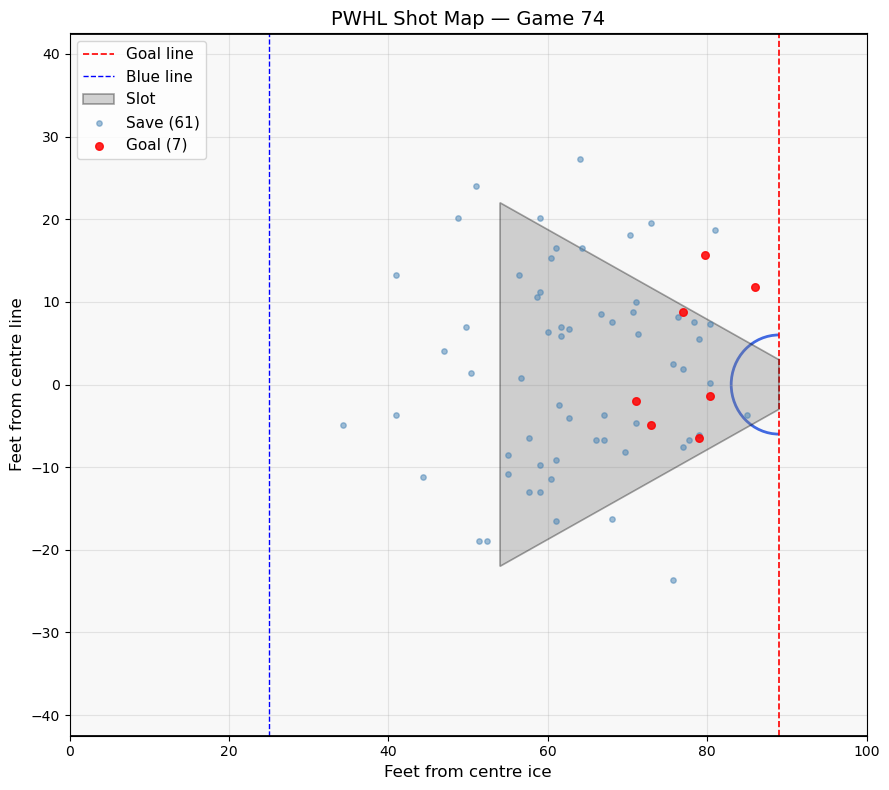

In [12]:
draw_shot_map(df_test,
              title=f"PWHL Shot Map — Game {TEST_GAME_ID}")

This seems to pass what a normal game would look like.

Most shots are clustered close to the net in the slot area.  Goals are also near the net.  Nothing stands out as an outlier and fit within the structure of the data.  Now we'll pull the data from all of the available games.

### Pulling Data For All PWHL Games

Everything passes an initial look, so we'll download the rest of the data, confirm that it has been scraped successfully and save the data in raw form.

Once completed, we will re-graph the complete shot data to see if any issues crop up.

In [13]:
all_rows = []
failed   = []

for i, gid in enumerate(all_game_ids):
    try:
        game_plays = get_plays(gid)
        rows       = parse_game(game_plays, gid)
        all_rows.extend(rows)
        print(f"  [{i+1:>3}/{len(all_game_ids)}] Game {gid}: {len(rows)} shots")
        time.sleep(0.5)
    except Exception as e:
        print(f"  [{i+1:>3}/{len(all_game_ids)}] Game {gid} FAILED: {e}")
        failed.append(gid)

df_all = pd.DataFrame(all_rows)
print(f"\nTotal shots:        {len(df_all)}")
print(f"Total goals:        {df_all['is_goal'].sum()}")
print(f"Overall shooting %: {df_all['is_goal'].mean():.3f}")
print(f"\nStrength state breakdown (home skaters vs away skaters):")
print(df_all.groupby(["home_team_skaters", "away_team_skaters"]).size().reset_index(name="shots"))
if failed:
    print(f"\nFailed games ({len(failed)}): {failed}")

df_all.to_csv("pwhl_shots_raw.csv", index=False)
print("\nSaved: pwhl_shots_raw.csv")

  [  1/271] Game 74: 68 shots
  [  2/271] Game 75: 65 shots
  [  3/271] Game 76: 57 shots
  [  4/271] Game 77: 81 shots
  [  5/271] Game 78: 65 shots
  [  6/271] Game 79: 65 shots
  [  7/271] Game 80: 68 shots
  [  8/271] Game 81: 65 shots
  [  9/271] Game 82: 60 shots
  [ 10/271] Game 2: 57 shots
  [ 11/271] Game 3: 51 shots
  [ 12/271] Game 4: 51 shots
  [ 13/271] Game 5: 68 shots
  [ 14/271] Game 6: 46 shots
  [ 15/271] Game 9: 67 shots
  [ 16/271] Game 8: 61 shots
  [ 17/271] Game 10: 50 shots
  [ 18/271] Game 11: 54 shots
  [ 19/271] Game 12: 70 shots
  [ 20/271] Game 13: 62 shots
  [ 21/271] Game 14: 54 shots
  [ 22/271] Game 15: 47 shots
  [ 23/271] Game 16: 52 shots
  [ 24/271] Game 17: 63 shots
  [ 25/271] Game 18: 51 shots
  [ 26/271] Game 19: 70 shots
  [ 27/271] Game 20: 72 shots
  [ 28/271] Game 21: 49 shots
  [ 29/271] Game 22: 67 shots
  [ 30/271] Game 23: 36 shots
  [ 31/271] Game 24: 71 shots
  [ 32/271] Game 25: 53 shots
  [ 33/271] Game 26: 73 shots
  [ 34/271] Game 

  [269/271] Game 269: 68 shots
  [270/271] Game 268: 56 shots
  [271/271] Game 270: 54 shots

Total shots:        15435
Total goals:        1297
Overall shooting %: 0.084

Strength state breakdown (home skaters vs away skaters):
   home_team_skaters  away_team_skaters  shots
0                  3                  3    234
1                  3                  4     29
2                  3                  5     57
3                  4                  3     51
4                  4                  4    147
5                  4                  5   1019
6                  5                  3     85
7                  5                  4   1196
8                  5                  5  12617

Saved: pwhl_shots_raw.csv


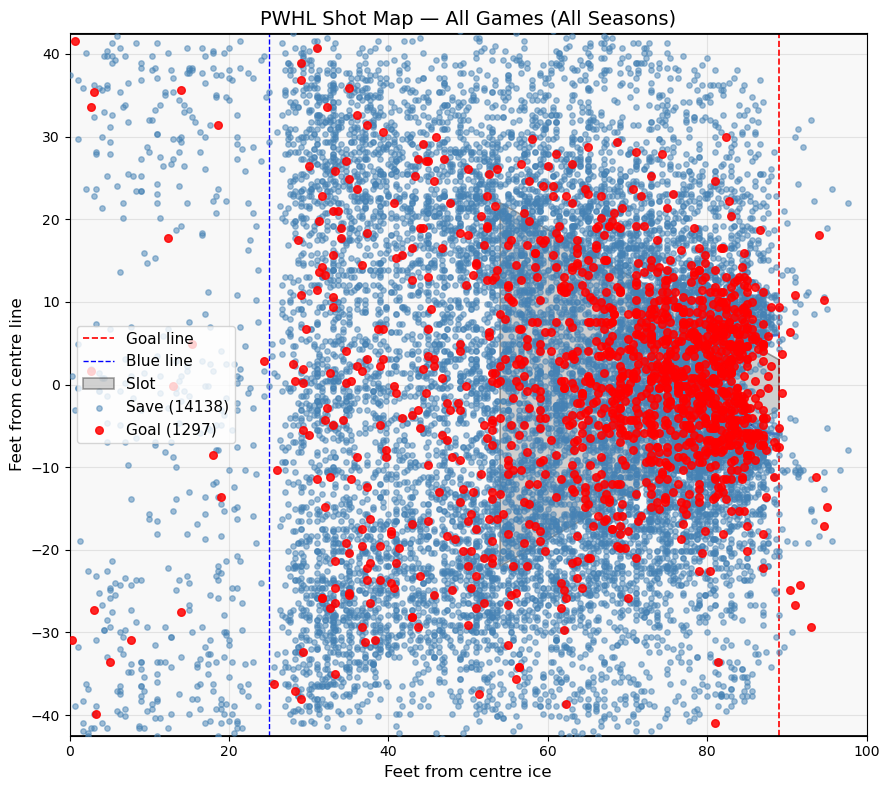

X range:        0.0 to 97.666667 ft
Y range:        -43.394737 to 45.184211 ft
Distance range: 1.1 to 97.6 ft
Angle range:    0.1 to 90.0 degrees


In [14]:
draw_shot_map(df_all,
              title="PWHL Shot Map — All Games (All Seasons)")

print(f"X range:        {df_all['x_ft'].min()} to {df_all['x_ft'].max()} ft")
print(f"Y range:        {df_all['y_ft'].min()} to {df_all['y_ft'].max()} ft")
print(f"Distance range: {df_all['dist_ft'].min()} to {df_all['dist_ft'].max()} ft")
print(f"Angle range:    {df_all['angle_deg'].min()} to {df_all['angle_deg'].max()} degrees")

The majority of this data looks pretty good.  The shots, as well as the goals, are heavily concentrated in the slot area.  Most shots and goals expand neatly out to make a concentrated trapezoid shape from the goal posts extending to the corners along the blue line.  This would seem to fit the pattern of normal game play.

There are a couple of issues:
- There are more goals that I would expect from the neutral zone.  Given the re-scaling, potential inaccurate tracking in early games and the possibility these being mostly Empty Net goals, I will be excluding these shots from the model.
- There is an inordinately high number of goals vs shots from behind the goal line.  Given that the data only includes 'shots on net' vs 'shots towards the net' an odd stat quirk pops up here.  A shot from behind the net CANNOT be 'on' the net due to the angle.  However, if it is deflected in (off the goalie or defence) then it becomes a goal and therefore a shot.  It looks like some of these attempts are tracked, but the quirk of this stat will make a shot from behind the net look 'too good' in the model so they will also not be included in the modelling.

As well, considering that `penalty_shot` occur outside of regular game play, and `empty_net` goals are by definition 100% goal rate, they will not be included either.

I'll now merge the player data with the shot data to finalize the PWHL data scrape.

In [15]:
pwhl_df = df_all.merge(
    df_skaters[['player_name', 'position']],
    on='player_name',
    how='left'
)

In [16]:
pwhl_df = pwhl_df[(pwhl_df['penalty_shot'] != 1) & (pwhl_df['empty_net'] != 1)].reset_index(drop = True)

<a id = 'loading'></a>

## 2. Loading PWHPA Data

In [17]:
pwhpa_df = pd.read_csv('23_PBP_WHKYHAC_SPORTLOGIQ.csv', encoding='latin-1')

In [18]:
pwhpa_df.head(1)

,seasonstage,date,teamname,opposingteamname,ishomegame,game,teaminpossession,currentpossession,period,compiledgametime,scoredifferential,strengthstate,teamskatersonicecount,opposingteamskatersonicecount,player,playerprimaryposition,goalie,opposing_goalie,eventname,outcome,type,xadjcoord,yadjcoord,xg_all_attempts,goal,createsrebound,onetimer,shotaim,shottype
0,regular,2022-10-15,Harvey's,Adidas,1,ADI-HAR,NaN,NaN,1,0.0,0,evenStrength,5,5,Marie-Philip Poulin,F,Ann-Renée Desbiens,Maddie Rooney,faceoff,successful,recoveredwithentry,-0.805328,0.755882,NaN,0,0,0,NaN,NaN


The data does not include an appropriate Game ID so we will need to create one based on `game`.

The PWHPA dataset is more broad, including ALL shot attempts with they made it to the net or not.  We will have to limit the shot data only to those that were 'successful' which denotes that the shot successfully made it to the net (but did not necessarily score).

I will be transforming column names to match the PWHL data as I go to make for a smooth merge when we are there, but we will add a `source` to delineate between the two leagues.

In [19]:
pwhpa_df['game_id'] = (pwhpa_df['game'] != pwhpa_df['game'].shift()).cumsum()
shots_pa = pwhpa_df[(pwhpa_df['eventname'] == 'shot') & (pwhpa_df['outcome'] == 'successful')].copy().reset_index(drop = True)

In [20]:
# Renaming coordinate columns first to aid in visualization
shots_pwhl = pwhl_df.copy()
shots_pwhl['source'] = 'PWHL'
shots_pa['is_goal'] = shots_pa['goal']
shots_pa['x_ft'] = shots_pa['xadjcoord']
shots_pa['y_ft'] = shots_pa['yadjcoord']

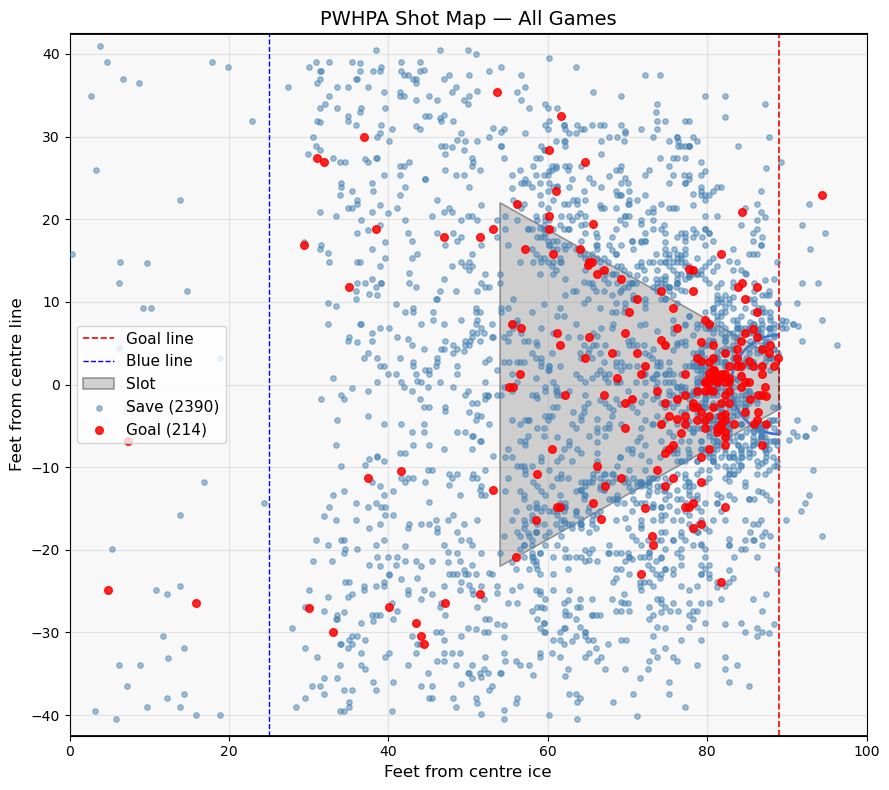

In [21]:
draw_shot_map(shots_pa,
              title="PWHPA Shot Map — All Games")

In [22]:
print(f"The PWHPA provides {round(len(shots_pa)/(len(shots_pwhl)+len(shots_pa)), 4)*100}% of the Total Shots")

The PWHPA provides 14.510000000000002% of the Total Shots


Even though the number of shots in the PWHPA dataset is less than the PWHL, given the infancy of the PWHL the PWHPA still provides a meaningful percentage of total shots which may help with modelling later so we are ready to merge these datasets.

<a id = 'merging'></a>

## Merging PWHL & PWHPA Datasets

In [23]:
# Aligning PWHPA data to the PWHL dataset
shots_pa['home_team']         = np.where(shots_pa['ishomegame'] == 1, shots_pa['teamname'], shots_pa['opposingteamname'])
shots_pa['away_team']         = np.where(shots_pa['ishomegame'] == 0, shots_pa['teamname'], shots_pa['opposingteamname'])
shots_pa['home_team_skaters'] = np.where(shots_pa['ishomegame'] == 1, shots_pa['teamskatersonicecount'], shots_pa['opposingteamskatersonicecount'])
shots_pa['away_team_skaters'] = np.where(shots_pa['ishomegame'] == 0, shots_pa['opposingteamskatersonicecount'], shots_pa['teamskatersonicecount'])
shots_pa['player_name']       = shots_pa['player']
shots_pa['position']          = shots_pa['playerprimaryposition']
shots_pa['player_team']       = shots_pa['teamname']
shots_pa['player_pos']        = shots_pa['playerprimaryposition']
shots_pa['goalie_name']       = shots_pa['goalie']
shots_pa['goalie_team']       = shots_pa['opposingteamname']
shots_pa['game_time']         = shots_pa['compiledgametime']
shots_pa['dist_ft']           = round(np.sqrt((shots_pa['x_ft'] - 89)**2 + shots_pa['y_ft']**2), 1)
shots_pa['angle_deg']         = round(np.degrees(np.arctan2(abs(shots_pa['y_ft']), abs(89 - shots_pa['x_ft']))), 1)
shots_pa['shot_type']         = shots_pa['shottype']
shots_pa['source']            = 'PWPHA'

In [24]:
SHARED_COLS = [
    'source',
    'game_id',
    'is_goal',
    'home_team',
    'away_team',
    'home_team_skaters',
    'away_team_skaters',
    'player_name',
    'position',
    'player_team',
    'goalie_name',
    'goalie_team',
    'game_time',
    'x_ft',
    'y_ft',
    'dist_ft',
    'angle_deg',
    'shot_type',
    'period'
    # PWHL-only — will be NaN for PWHPA rows
    #'time', 's',
    #'shot_description',
    #'penalty_shot',
    #'empty_net'
    #'event_id',
    #'x_raw', 'y_raw',
]

In [25]:
pa_cols   = [c for c in SHARED_COLS if c in shots_pa.columns]
pwhl_cols = [c for c in SHARED_COLS if c in shots_pwhl.columns]

In [26]:
# Merging common columns
df = pd.concat(
    [shots_pwhl[pwhl_cols], shots_pa[pa_cols]],
    ignore_index=True
)

print(f"PWHL shots:  {len(shots_pwhl)}")
print(f"PWHPA shots: {len(shots_pa)}")
print(f"Combined:    {len(df)}")
print(f"\nGoal rate by source:")
print(df.groupby('source')['is_goal'].mean().round(3))
print(f"\nNull counts in key columns:")
print(df[['dist_ft', 'angle_deg', 'shot_type', 'home_team_skaters']].isnull().sum())

PWHL shots:  15347
PWHPA shots: 2604
Combined:    17951

Goal rate by source:
source
PWHL     0.080
PWPHA    0.082
Name: is_goal, dtype: float64

Null counts in key columns:
dist_ft              0
angle_deg            0
shot_type            0
home_team_skaters    0
dtype: int64


It is promising that the `is_goal` rate is very similar between the two leagues.  Given that many players played in both leagues, this suggests that they are similar enough in the style and quality of play that they could be equally judged.  We will keep the `source` for modelling, but this is promising to create a deeper dataset to build a more reliable model for future use.

<a id = 'finalizing'></a>

## Finalizing Clean Full Dataset

In the exploration of the finalized dataset, the PWHL and the PWHPA handled Empty Net goals differently, with the PWHPA having a `null` value in for the goalie.  These shots will be dropped from the data.

Then to order the dataset in as close to chronological order as possible, we will order it by `source` (with the PWHPA season happening before the PWHL seasons), then `game_id` and `game_time`.

Then we will have a look at the shot chart with the full dataset.

In [27]:
df = df.dropna(subset=['goalie_name'])

In [28]:
df = df.sort_values(by = ['source', 'game_id', 'game_time'], ascending = [False, True, True]).reset_index(drop = True)

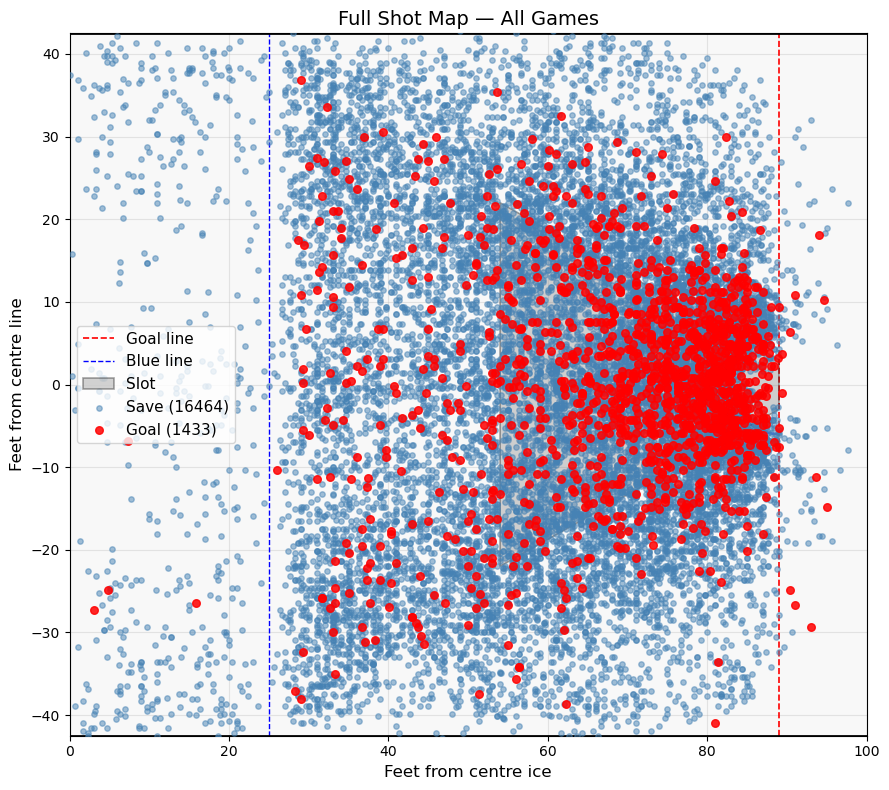

In [29]:
draw_shot_map(df,
              title="Full Shot Map — All Games")

Not including Empty Net goals did not get rid of the number of goals from beyond the blue line.  The number of goals seems inordinately high relative to the number of shots still, and definitely a higher probability than would be realistic in normal game settings.  Therefore we will not include any shots that happen beyond the blue line and focus on shots that only occur in the attacking zone.

Given the stat quirk discussed already, we will also not include shots that happen from behind the goal line.

Lastly, given the different OT rules across the different leagues and times of season, the sample and nature of Overtime shots may skew the data in a way that does not reflect the vast majority of game play.  Therefore we will not include any shots that occur after the third period either.

In [30]:
df = df[(df['x_ft'] >= 25) & (df['x_ft'] <= 89) & (df['period'] < 4)].reset_index(drop=True)

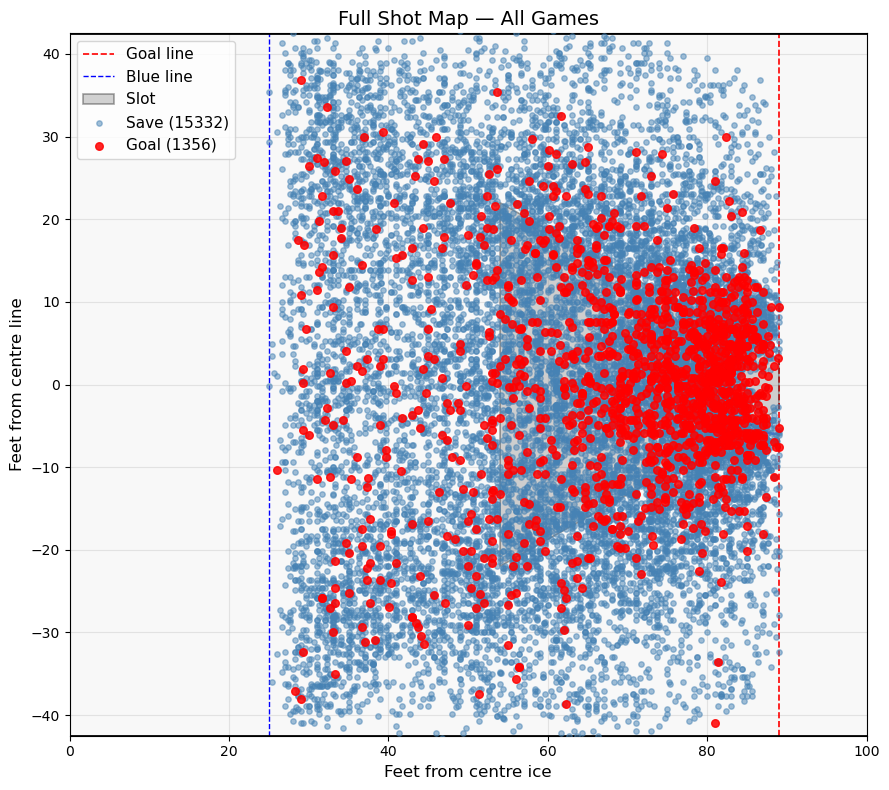

Total Shots: 16688
Total Goals: 1356
Goal rate: 8.1%


In [31]:
draw_shot_map(df,
              title="Shot Map: Between Goal and Blue Lines — All Games")
print(f"Total Shots: {len(df)}")
print(f"Total Goals: {df['is_goal'].sum()}")
print(f"Goal rate: {df['is_goal'].mean().round(3)*100}%")

In [32]:
df

,source,game_id,is_goal,home_team,away_team,home_team_skaters,away_team_skaters,player_name,position,player_team,goalie_name,goalie_team,game_time,x_ft,y_ft,dist_ft,angle_deg,shot_type,period
0,PWPHA,1,0,Harvey's,Adidas,5,5,Hayley Scamurra,F,Harvey's,Ann-Renée Desbiens,Adidas,30.266666,75.142281,15.844118,21.0,48.8,snapshot,1
1,PWPHA,1,0,Harvey's,Adidas,5,5,Sarah Potomak,F,Adidas,Maddie Rooney,Harvey's,57.900000,81.272430,-0.252941,7.7,1.9,snapshot,1
2,PWPHA,1,0,Harvey's,Adidas,5,5,Kendall Coyne Schofield,F,Adidas,Maddie Rooney,Harvey's,134.866670,85.295959,-36.464706,36.7,84.2,snapshot,1
3,PWPHA,1,0,Harvey's,Adidas,5,5,Laura Fortino,D,Harvey's,Ann-Renée Desbiens,Adidas,298.133330,67.598160,0.252941,21.4,0.7,wristshot,1
4,PWPHA,1,0,Harvey's,Adidas,5,5,Lee Stecklein,D,Harvey's,Ann-Renée Desbiens,Adidas,301.500000,43.458725,-32.444130,55.9,35.5,wristshot,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16683,PWHL,337,0,MTL,BOS,5,5,Megan Keller,D,BOS,Sandra Abstreiter,MTL,3041.000000,70.000000,-20.429825,27.9,47.1,Slap,3
16684,PWHL,337,0,MTL,BOS,4,5,Jamie Lee Rattray,F,BOS,Sandra Abstreiter,MTL,3261.000000,71.333333,-0.447368,17.7,1.5,Tip,3
16685,PWHL,337,0,MTL,BOS,4,5,Jamie Lee Rattray,F,BOS,Sandra Abstreiter,MTL,3265.000000,75.000000,2.236842,14.2,9.1,Backhand,3
16686,PWHL,337,0,MTL,BOS,5,5,Laura Stacey,F,MTL,Amanda Thiele,BOS,3341.000000,73.333333,5.517544,16.6,19.4,Tip,3


With the data filtered to be focused between the blue line and the goal line for regulation periods, we are ready analyze the data further in preparation for modelling.

In [33]:
df.to_csv('all_shots.csv', index=False)